# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?
* The objective of this project is to improve Zillow's property valuation accuracy through predicting a home's assessed tax value (identified by taxdollarcnt) using historical property data. Modeling can be done through using variables such as square footage, room counts, and amenities. Having a more reliable model enables Zillow tools such as Zestimates, guide pricing strategies, and supports buyers and sellers with data-backed decisions in the real estate market.

**1.2:**  How will your solution be used?
* The model (/the solution) will be integrated into Zillow's pricing and recommendation engines to provide more accurate property estimates in real time. This can improve several areas within Zillow. The marketing team can use data segmentation, detected trends, and personalized campaigns for property listings and financial services. This can also improve user experience by providing smarter and more accurate filters and property suggestions. 


**1.3:**  How should success (or failure) be measured?
* Success should be measure based on how accurately the model precists the assessed tax value (identified by taxvaluedollarcnt) on unseen properties. A strong metric to do this is Root Mean Squared Error (RMSE) as this penalizes large errors more heavily, preventing percentage errors that can correlate to thousands of dollars in the real estate market. Additionally, performance should also be evaluated via cross validation to ensure generalizability. Success could also be measured by the interpretability of the model, its computational efficiency, and how well the mdoel integrates with Zillow's existing platform and business workflows. Failure would include high error variance, poor performance on real-world properties and listings, or a model that is too complex to interpret and deploy efficiently. 

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [3]:
#first 5 rows of the dataset
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [4]:
# Dataset information: columns, data types, and missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [5]:
#number of unique values in each column
unique_counts = df.nunique().sort_values(ascending=False)
#display the unique counts
print("Number of unique values in each column:")
print(unique_counts)


Number of unique values in each column:
parcelid                        77414
latitude                        64038
longitude                       62461
taxvaluedollarcnt               50949
rawcensustractandblock          39188
censustractandblock             39006
lotsizesquarefeet               18848
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
propertyzoningdesc               1907
finishedsquarefeet50             1807
finishedfloor1squarefeet         1787
finishedsquarefeet15             1724
garagetotalsqft                   839
yardbuildingsqft17                540
regionidneighborhood              480
regionidzip                       389
finishedsquarefeet6               350
poolsizesum                       262
regionidcity                      175
yearbuilt                         136
propertycountylandusecode          75
yardbuildingsqft26                 59
basementsqft                       43
bathroomcnt                        22
calculated

In [6]:
#percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100
#display the missing percentage
print("Percentage of missing values in each column:")
print(missing_percentage.sort_values(ascending=False))

Percentage of missing values in each column:
buildingclasstypeid             99.980673
finishedsquarefeet13            99.945885
basementsqft                    99.935578
storytypeid                     99.935578
yardbuildingsqft26              99.909809
fireplaceflag                   99.778388
architecturalstyletypeid        99.733292
typeconstructiontypeid          99.712677
finishedsquarefeet6             99.502661
pooltypeid10                    99.400874
decktypeid                      99.208895
poolsizesum                     98.880342
pooltypeid2                     98.616211
hashottuborspa                  98.017085
yardbuildingsqft17              96.916754
taxdelinquencyyear              96.263513
taxdelinquencyflag              96.263513
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedfloor1squarefeet        92.221664
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
pooltypeid7                    

In [7]:
# summary statistics of the dataset
summary_stats = df.describe()
#display the summary statistics
print("Summary statistics of the dataset:")
print(summary_stats)


Summary statistics of the dataset:
           parcelid  airconditioningtypeid  architecturalstyletypeid  \
count  7.761300e+04           25007.000000                207.000000   
mean   1.300781e+07               1.812013                  7.386473   
std    3.518717e+06               2.965768                  2.728030   
min    1.071186e+07               1.000000                  2.000000   
25%    1.153821e+07               1.000000                  7.000000   
50%    1.253004e+07               1.000000                  7.000000   
75%    1.421101e+07               1.000000                  7.000000   
max    1.676893e+08              13.000000                 21.000000   

       basementsqft   bathroomcnt    bedroomcnt  buildingclasstypeid  \
count     50.000000  77579.000000  77579.000000            15.000000   
mean     679.720000      2.298496      3.053223             3.933333   
std      689.703546      0.996732      1.140480             0.258199   
min       38.000000      0.0

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

The following features are categorical 
- propertycountylandusecode 
- propertyzoningdesc
- hashottuborspa
- taxdelinquencyflag
- fireplaceflag
- airconditioningtypeid 
- heatingorsystemtypeid

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 



**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 



**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

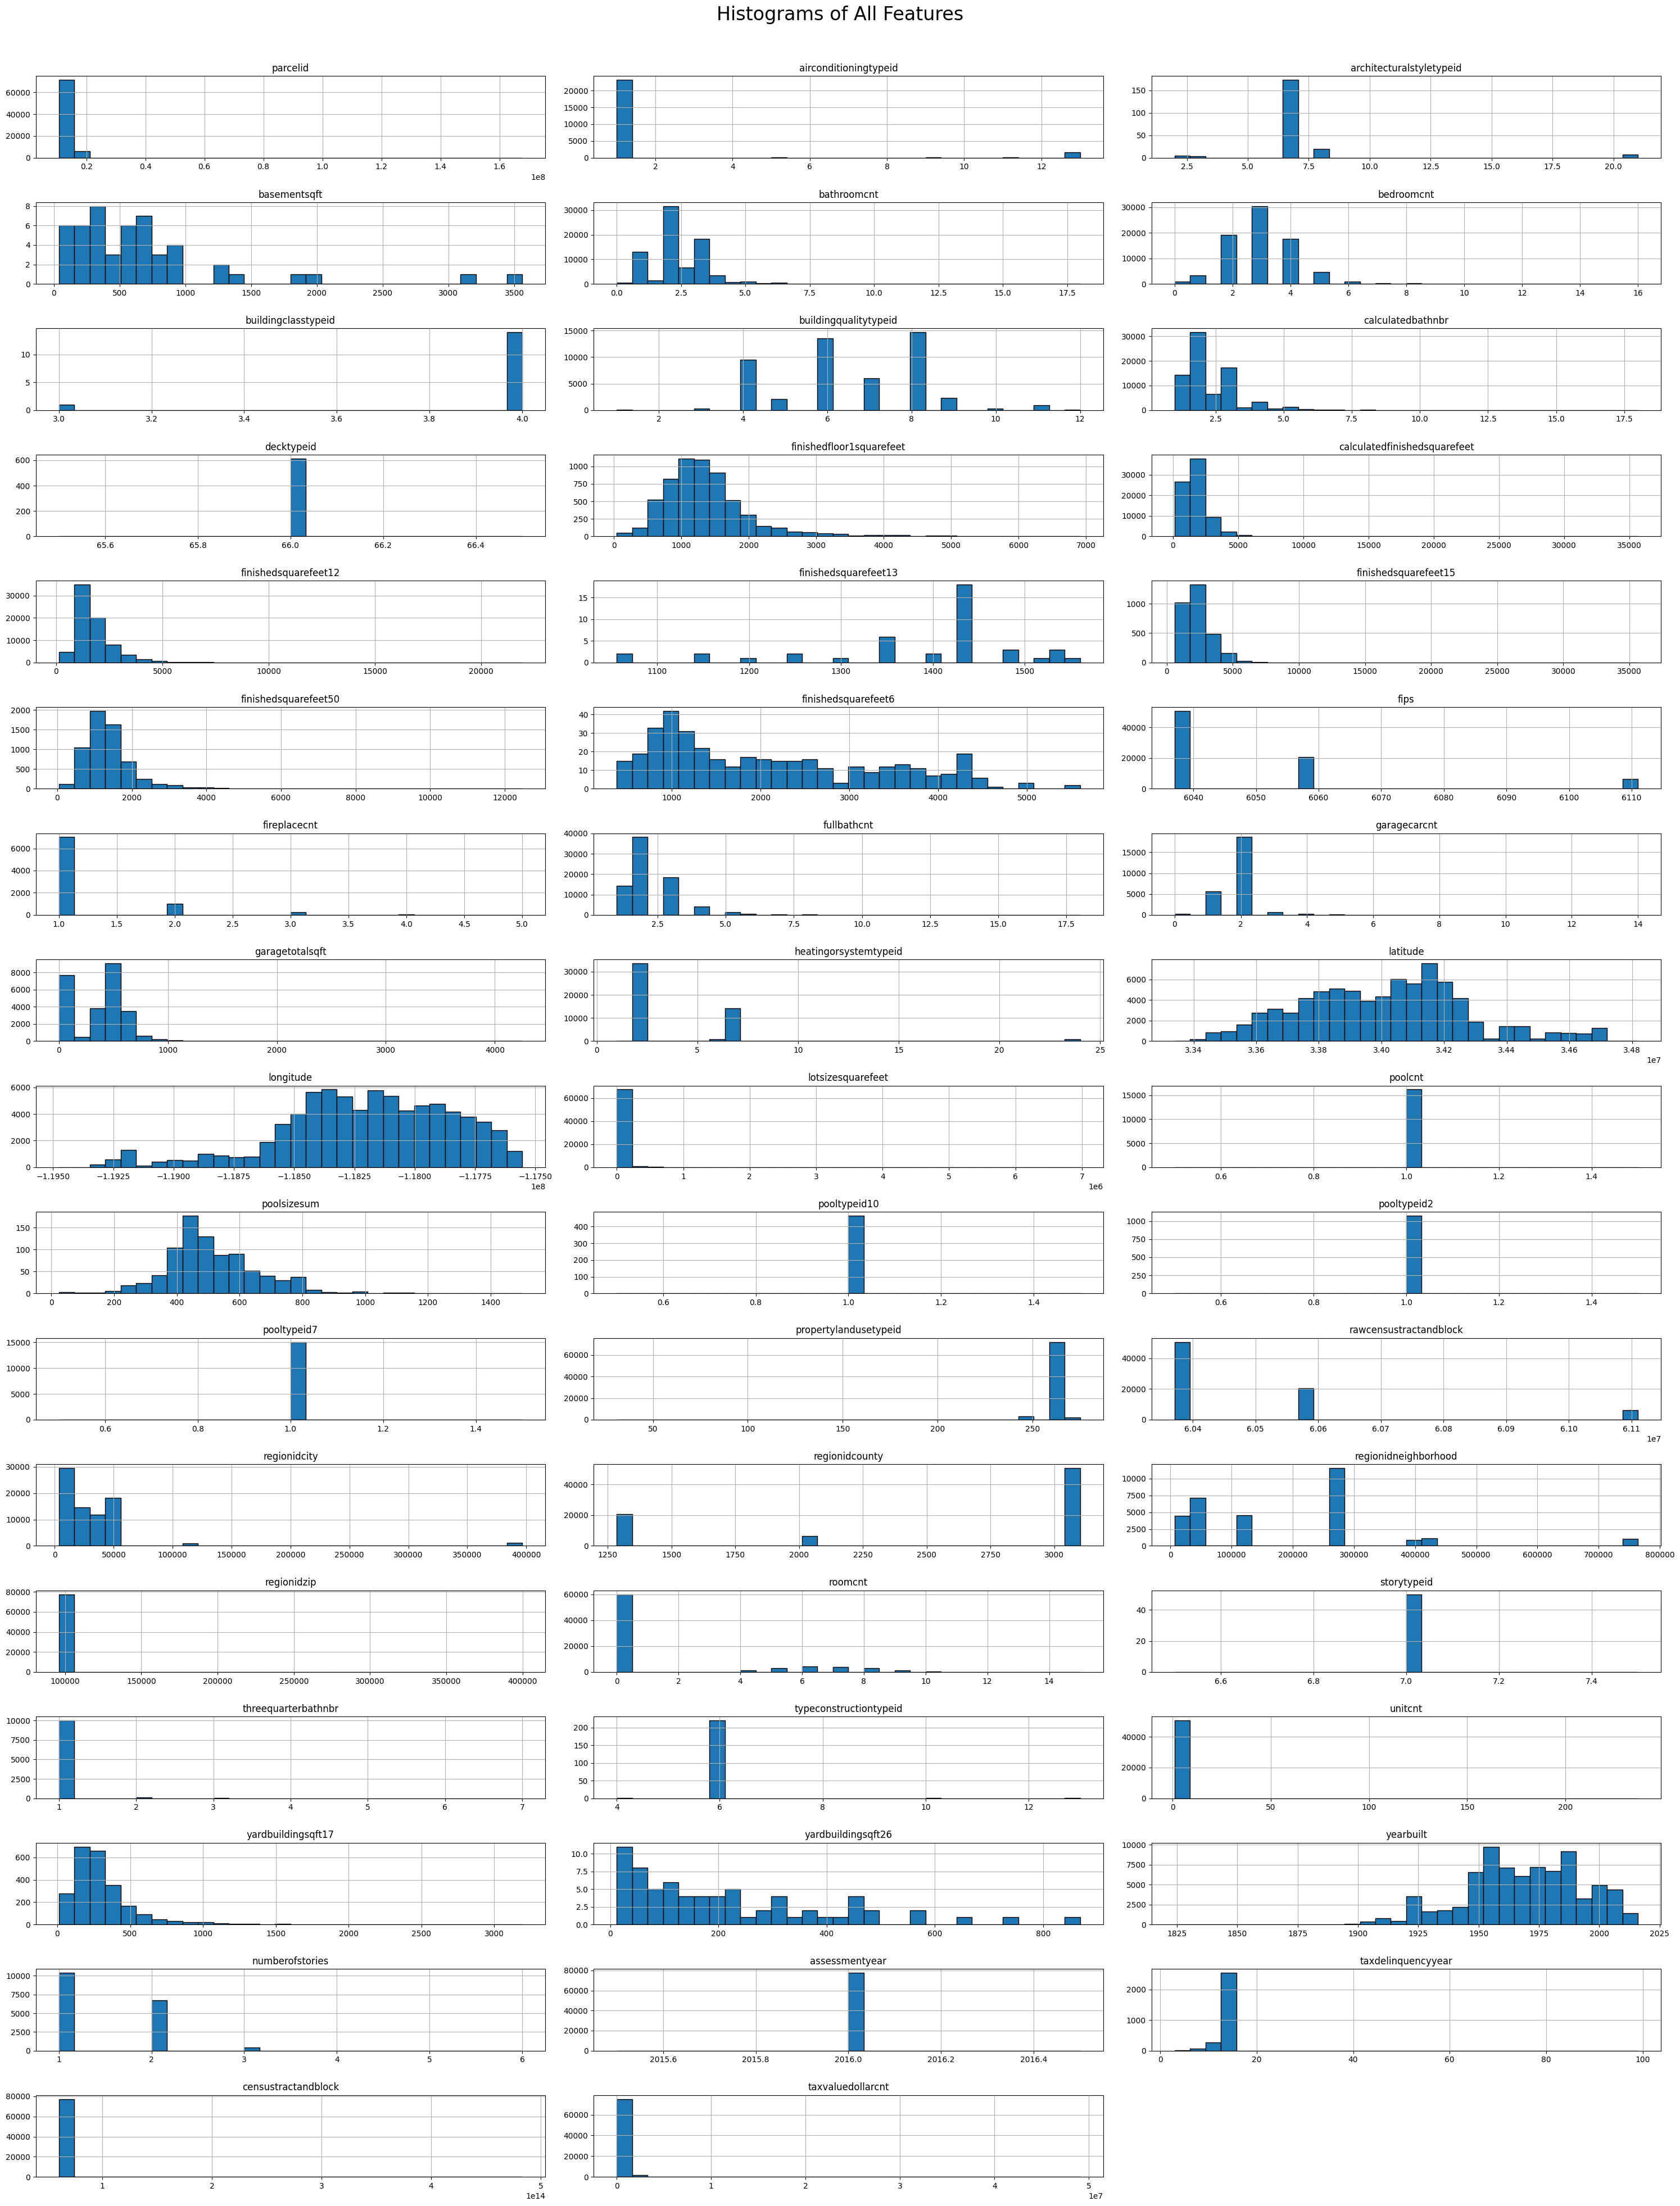

In [8]:
#histograms of all features
df.hist(figsize=(30, 40), layout=(-1, 3), bins=30, edgecolor='black')

#plot layout
plt.suptitle("Histograms of All Features", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.97])  
plt.show()


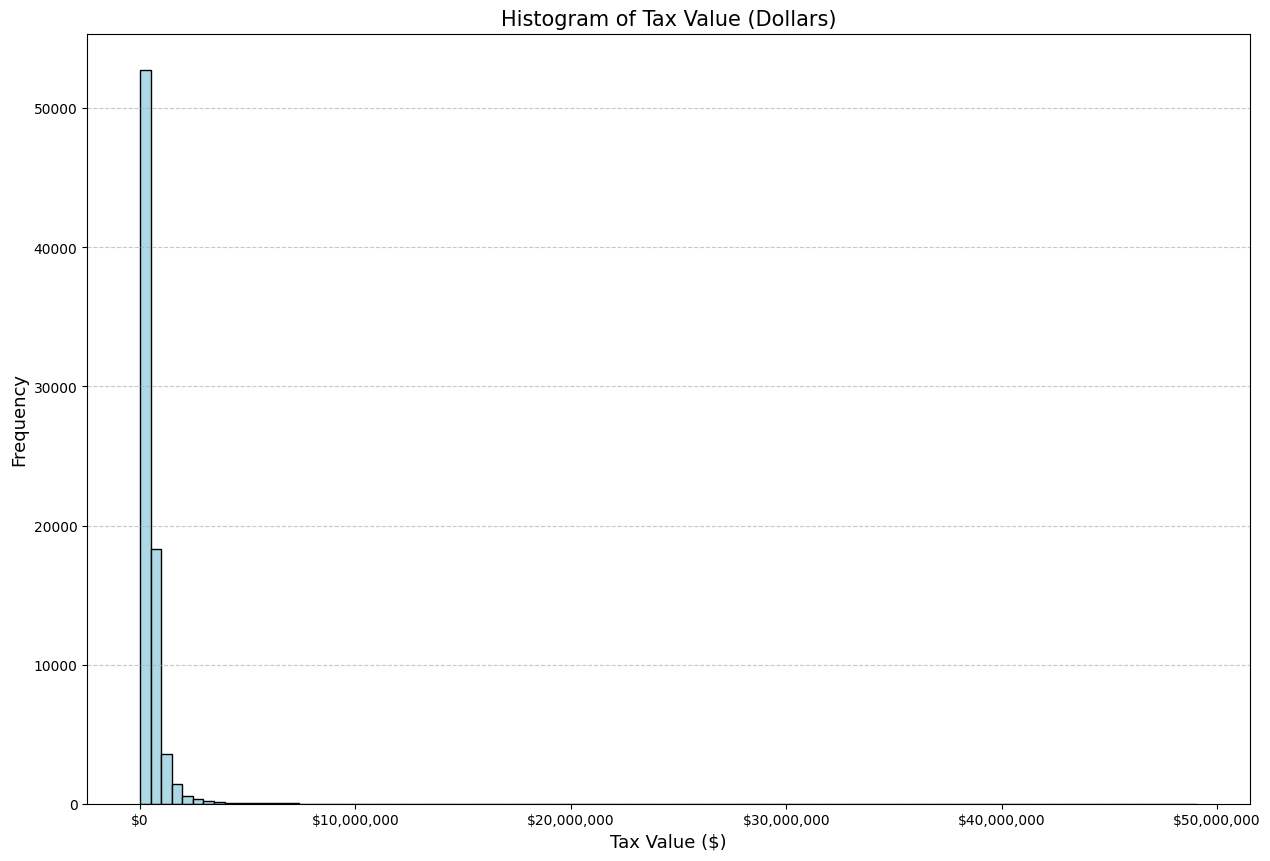

In [9]:
#histogram of taxvaluedollarcnt
plt.figure(figsize=(15, 10))
plt.hist(df['taxvaluedollarcnt'], bins=100, edgecolor='black', color='lightblue')
plt.title("Histogram of Tax Value (Dollars)", fontsize=15)
plt.xlabel("Tax Value ($)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

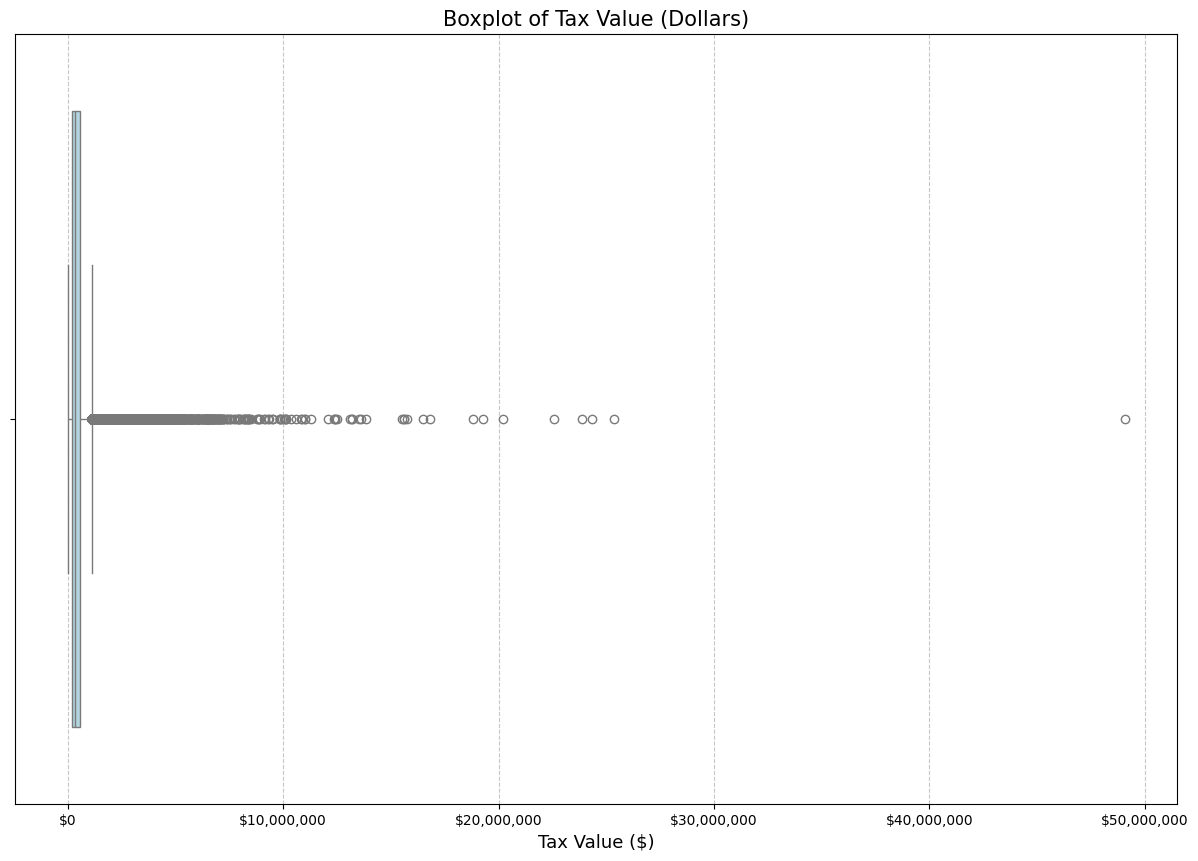

In [10]:
#boxplot of taxvaluedollarcnt
plt.figure(figsize=(15, 10))
sns.boxplot(x=df['taxvaluedollarcnt'], color='lightblue')
plt.title("Boxplot of Tax Value (Dollars)", fontsize=15)
plt.xlabel("Tax Value ($)", fontsize=13)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


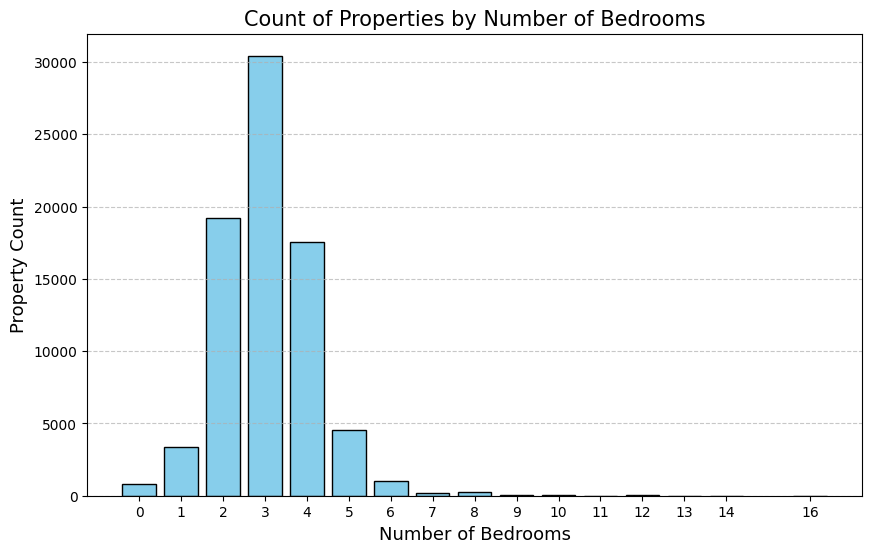

In [11]:

#bar plot for bedroom count
bedroom_counts = df['bedroomcnt'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(bedroom_counts.index, bedroom_counts.values, color='skyblue', edgecolor='black')

plt.title("Count of Properties by Number of Bedrooms", fontsize=15)
plt.xlabel("Number of Bedrooms", fontsize=13)
plt.ylabel("Property Count", fontsize=13)
plt.xticks(bedroom_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

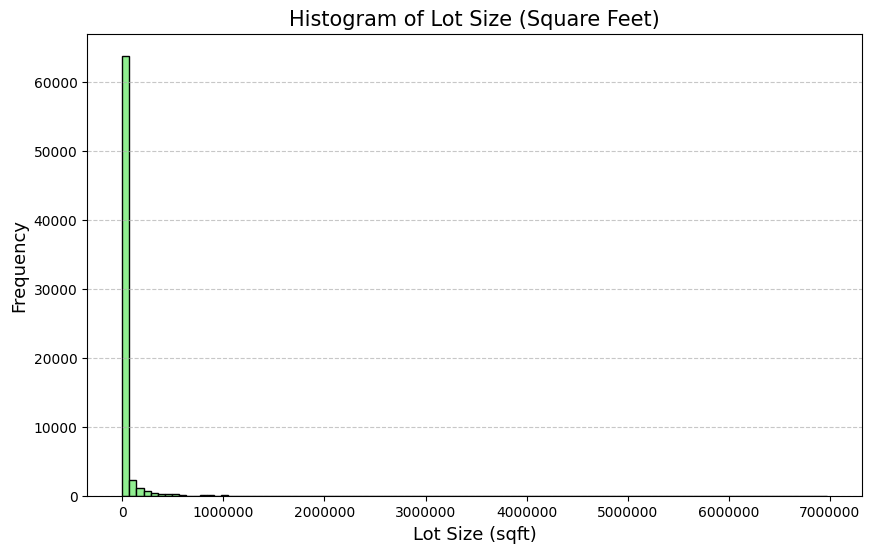

In [12]:
#histogram of lot sizes
plt.figure(figsize=(10, 6))

plt.hist(df['lotsizesquarefeet'].dropna(), bins=100, edgecolor='black', color='lightgreen')
plt.title("Histogram of Lot Size (Square Feet)", fontsize=15)
plt.xlabel("Lot Size (sqft)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)

plt.ticklabel_format(style='plain', axis='x')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

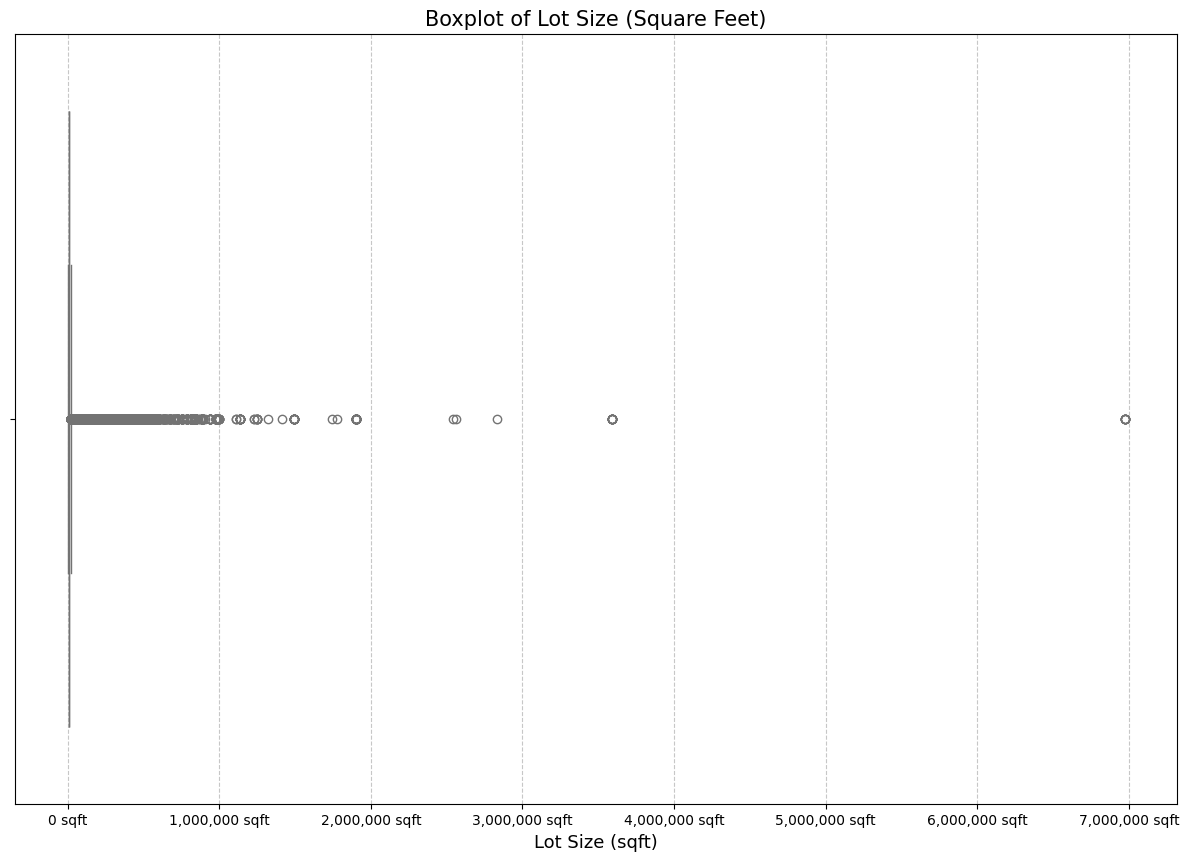

In [13]:
#boxplot of lotsizesquarefeet
plt.figure(figsize=(15, 10))
sns.boxplot(x=df['lotsizesquarefeet'], color='lightgreen')
plt.title("Boxplot of Lot Size (Square Feet)", fontsize=15)
plt.xlabel("Lot Size (sqft)", fontsize=13)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,} sqft'))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [14]:
#method to drop columns 
def drop_unsuitable_features(df, columns):

    """
    Drops specified features from the DataFrame.
    
    Parameters:
    - df: pandas DataFrame
    - columns: single column name (str) or list of column names (list of str)
    
    Returns:
    - df_dropped: DataFrame with specified columns removed
    """
    #checks to see if columns is a list 
    if isinstance(columns, str):
        columns = [columns]
    
    df_dropped = df.drop(columns=columns, errors='ignore')
    return df_dropped

#drop unsuitable features
unsuitable_columns = [
    'parcelid',               #unique identifier
    'assessmentyear',         #only 1 value (2016)
    'censustractandblock',    #too granular
    'rawcensustractandblock', #redundant
    'propertyzoningdesc'      #too noisy
]

df_dropped_unsuitable = drop_unsuitable_features(df, unsuitable_columns)

print(f"Original shape: {df.shape}")
print(f"Shape after dropping unsuitable features: {df_dropped_unsuitable.shape}")

Original shape: (77613, 55)
Shape after dropping unsuitable features: (77613, 50)


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [15]:
#method to drop columns with too many missing values
def drop_high_missing_features(df, threshold=0.85):
    """
    Drops features with more than a specified percentage of missing values.
    
    Parameters:
    - df: pandas DataFrame
    - threshold: float, percentage threshold (default is 0.85 for 85%)
    
    Returns:
    - df_dropped: DataFrame with high missing value features removed
    """
    missing_percentage = df.isnull().mean()
    columns_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()
    df_dropped = df.drop(columns=columns_to_drop)
    return df_dropped, columns_to_drop


#apply function to the dataset
df_dropped_high_null, dropped_columns = drop_high_missing_features(df_dropped_unsuitable, threshold=0.85)

#results
print(f"Columns dropped (more than 85% nulls): {dropped_columns}")
print(f"Original shape: {df_dropped_unsuitable.shape}")
print(f"Shape after dropping high-null columns: {df_dropped_high_null.shape}")

Columns dropped (more than 85% nulls): ['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'hashottuborspa', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']
Original shape: (77613, 50)
Shape after dropping high-null columns: (77613, 28)


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [16]:
#method to drop problematic features
def drop_problematic_samples(df, target_col, row_null_threshold=0.50, outlier_percentile=0.99):
    """
    Drops problematic samples from the dataset:
    - Rows with null target values
    - Rows with too many nulls
    - Outliers in the target column
    
    Parameters:
    - df: pandas DataFrame
    - target_col: str, name of the target variable
    - row_null_threshold: float, fraction of nulls in a row to consider it problematic
    - outlier_percentile: float, percentile threshold to remove extreme target outliers
    
    Returns:
    - df_cleaned: cleaned DataFrame
    """
    initial_shape = df.shape
    
    #drop rows with null target
    df_cleaned = df.dropna(subset=[target_col])
    
    #drop rows with too many nulls
    row_null_fraction = df_cleaned.isnull().mean(axis=1)
    df_cleaned = df_cleaned[row_null_fraction <= row_null_threshold]
    
    #drop outliers in target
    target_upper_limit = df_cleaned[target_col].quantile(outlier_percentile)
    df_cleaned = df_cleaned[df_cleaned[target_col] <= target_upper_limit]
    
    print(f"Original shape: {initial_shape}")
    print(f"Shape after cleaning: {df_cleaned.shape}")
    print(f"Rows dropped: {initial_shape[0] - df_cleaned.shape[0]}")
    
    return df_cleaned

#apply method to cleaned dataset
df_final_cleaned = drop_problematic_samples(df_dropped_high_null, target_col='taxvaluedollarcnt')

#cleaned dataset
df_final_cleaned.head()

Original shape: (77613, 28)
Shape after cleaning: (76644, 28)
Rows dropped: 969


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,...,propertylandusetypeid,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,numberofstories,taxvaluedollarcnt
0,NaN,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,3.0,2.0,...,261.0,53571.0,1286.0,NaN,96978.0,0.0,NaN,1998.0,NaN,1023282.0
1,NaN,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,1.0,...,261.0,13091.0,2061.0,NaN,97099.0,5.0,NaN,1967.0,1.0,464000.0
2,NaN,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,2.0,...,261.0,21412.0,1286.0,NaN,97078.0,6.0,NaN,1962.0,1.0,564778.0
3,NaN,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,NaN,...,261.0,396551.0,3101.0,NaN,96330.0,0.0,1.0,1970.0,NaN,145143.0
4,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,NaN,...,266.0,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1964.0,NaN,119407.0


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [17]:
#method to impute remaining null values

def impute_missing_values(df):
    """
    Impute missing values in numerical and categorical columns using
    appropriate methods.
    - Numerical: median imputation (robust to outliers)
    - Categorical: mode imputation or 'Unknown' category
    """
    df_imputed = df.copy()
    
    #seperate numeric and categorical columns
    numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns
    
    #impute numeric columns using median (robust to outliers)
    for col in numeric_cols:
        median_value = df_imputed[col].median()
        df_imputed[col].fillna(median_value, inplace=True)
    
    #impute categorical columns using mode or 'Unknown'
    for col in categorical_cols:
        if df_imputed[col].isnull().any():
            mode_value = df_imputed[col].mode().iloc[0]
            df_imputed[col].fillna(mode_value, inplace=True)
    
    return df_imputed

#use method
df_imputed = impute_missing_values(df_final_cleaned)

#confirm no remaining null values
print(f"Remaining null values: \n{df_imputed.isnull().sum().sum()}")

Remaining null values: 
0


/tmp/ipykernel_65404/2357693201.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[col].fillna(median_value, inplace=True)
/tmp/ipykernel_65404/2357693201.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [18]:
#method to encode categorical features using ordinal encoding
def encode_categorical_features(df):
    """
    Encode categorical features using ordinal encoding.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - df_encoded: DataFrame with categorical features encoded
    """
    df_encoded = df.copy()
    
    #identify categorical columns
    categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if categorical_cols:
        encoder = OrdinalEncoder()
        df_encoded[categorical_cols] = encoder.fit_transform(df_encoded[categorical_cols])
        print(f"Encoded categorical columns: {categorical_cols}")
    else:
        print("No categorical features to encode.")
    
    return df_encoded

#encode categorical features
df_encoded = encode_categorical_features(df_imputed)

#see results
df_encoded.head()

Encoded categorical columns: ['propertycountylandusecode']


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,...,propertylandusetypeid,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,numberofstories,taxvaluedollarcnt
0,1.0,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,2.0,...,261.0,53571.0,1286.0,118849.0,96978.0,0.0,1.0,1998.0,1.0,1023282.0
1,1.0,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,1.0,...,261.0,13091.0,2061.0,118849.0,97099.0,5.0,1.0,1967.0,1.0,464000.0
2,1.0,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,2.0,...,261.0,21412.0,1286.0,118849.0,97078.0,6.0,1.0,1962.0,1.0,564778.0
3,1.0,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,...,261.0,396551.0,3101.0,118849.0,96330.0,0.0,1.0,1970.0,1.0,145143.0
4,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,...,266.0,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1964.0,1.0,119407.0


In [19]:
#final cleaned and encoded dataset
df_final= df_encoded.copy()

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

##### Compute and analyze pairwise correlations using a correlation matrix:

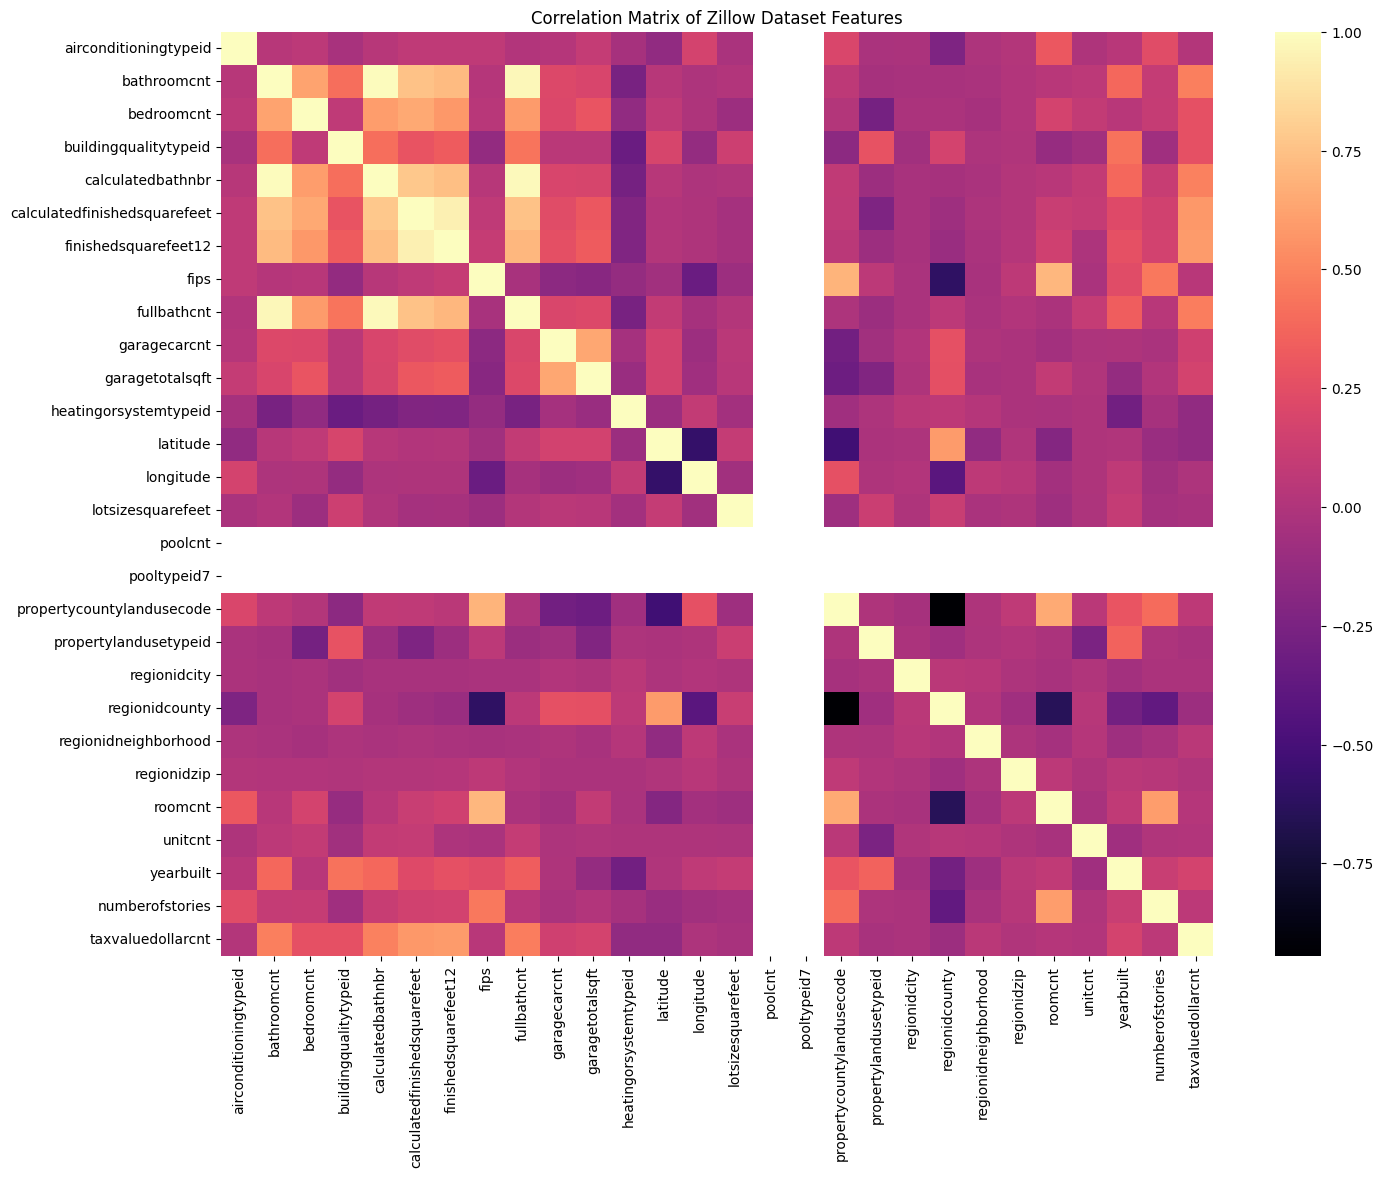

In [20]:
corr_matrix = df_final.corr()
#plot correlation matrix
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, cmap='magma')
plt.title('Correlation Matrix of Zillow Dataset Features')
plt.show()

The heatmap around poolcnt and pooltypeid seems abnormal. This can be due to low correlation or low variance in these columns.

In [21]:
#check correlation of poolcnt w/rest of features
print(corr_matrix.loc['poolcnt'].sort_values(ascending=False))

airconditioningtypeid          NaN
bathroomcnt                    NaN
bedroomcnt                     NaN
buildingqualitytypeid          NaN
calculatedbathnbr              NaN
calculatedfinishedsquarefeet   NaN
finishedsquarefeet12           NaN
fips                           NaN
fullbathcnt                    NaN
garagecarcnt                   NaN
garagetotalsqft                NaN
heatingorsystemtypeid          NaN
latitude                       NaN
longitude                      NaN
lotsizesquarefeet              NaN
poolcnt                        NaN
pooltypeid7                    NaN
propertycountylandusecode      NaN
propertylandusetypeid          NaN
regionidcity                   NaN
regionidcounty                 NaN
regionidneighborhood           NaN
regionidzip                    NaN
roomcnt                        NaN
unitcnt                        NaN
yearbuilt                      NaN
numberofstories                NaN
taxvaluedollarcnt              NaN
Name: poolcnt, dtype

In [22]:
#check correlation of poolcnt w/rest of features
print(corr_matrix.loc['pooltypeid7'].sort_values(ascending=False))

airconditioningtypeid          NaN
bathroomcnt                    NaN
bedroomcnt                     NaN
buildingqualitytypeid          NaN
calculatedbathnbr              NaN
calculatedfinishedsquarefeet   NaN
finishedsquarefeet12           NaN
fips                           NaN
fullbathcnt                    NaN
garagecarcnt                   NaN
garagetotalsqft                NaN
heatingorsystemtypeid          NaN
latitude                       NaN
longitude                      NaN
lotsizesquarefeet              NaN
poolcnt                        NaN
pooltypeid7                    NaN
propertycountylandusecode      NaN
propertylandusetypeid          NaN
regionidcity                   NaN
regionidcounty                 NaN
regionidneighborhood           NaN
regionidzip                    NaN
roomcnt                        NaN
unitcnt                        NaN
yearbuilt                      NaN
numberofstories                NaN
taxvaluedollarcnt              NaN
Name: pooltypeid7, d

The actual correlation values being all NaN across both poolcnt and pooltypeid7. Next, we will check if there are unique values and the value counts of these features to determine if they are useful to the model:

In [23]:
print("Unique values in poolcnt:", df_final['poolcnt'].unique())
print("Value counts (normalized):")
print(df_final['poolcnt'].value_counts(normalize=True))
print("\nUnique values in pooltypeid7:", df_final['pooltypeid7'].unique())
print("Value counts (normalized):")
print(df_final['pooltypeid7'].value_counts(normalize=True))

Unique values in poolcnt: [1.]
Value counts (normalized):
poolcnt
1.0    1.0
Name: proportion, dtype: float64

Unique values in pooltypeid7: [1.]
Value counts (normalized):
pooltypeid7
1.0    1.0
Name: proportion, dtype: float64


From this, we can see that poolcnt and pooltypeid7 are constant columns and therefore have no predictive power. 

In [24]:
#drop poolcnt and pooltypeid7
def drop_constant_columns(df):
    """
    Drops columns that have the same value across all rows.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - df_cleaned: DataFrame without constant columns
    - dropped_cols: List of columns dropped
    """
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    df_cleaned = df.drop(columns=constant_cols)
    return df_cleaned, constant_cols

# Apply it to your dataset
df_final, dropped_constant_cols = drop_constant_columns(df_final)

print(f"Constant columns dropped: {dropped_constant_cols}")

Constant columns dropped: ['poolcnt', 'pooltypeid7']


Plotting the final heatmap:

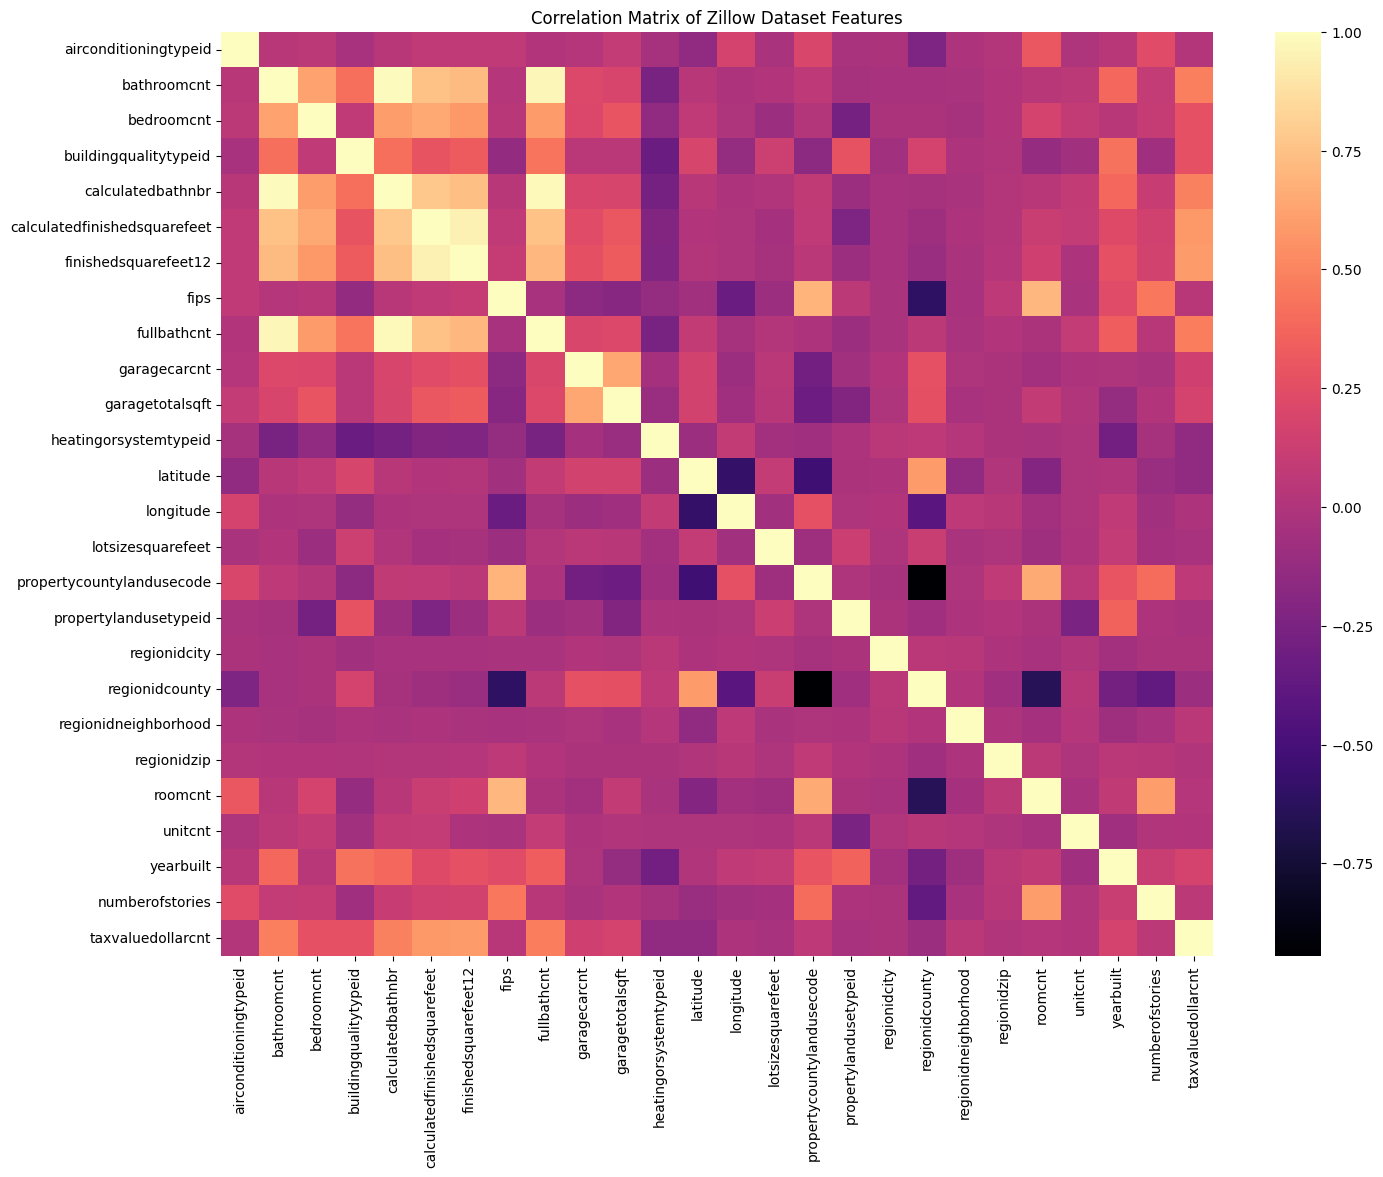

In [25]:
corr_matrix = df_final.corr()
#plot correlation matrix
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, cmap='magma')
plt.title('Correlation Matrix of Zillow Dataset Features')
plt.show()

##### Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 

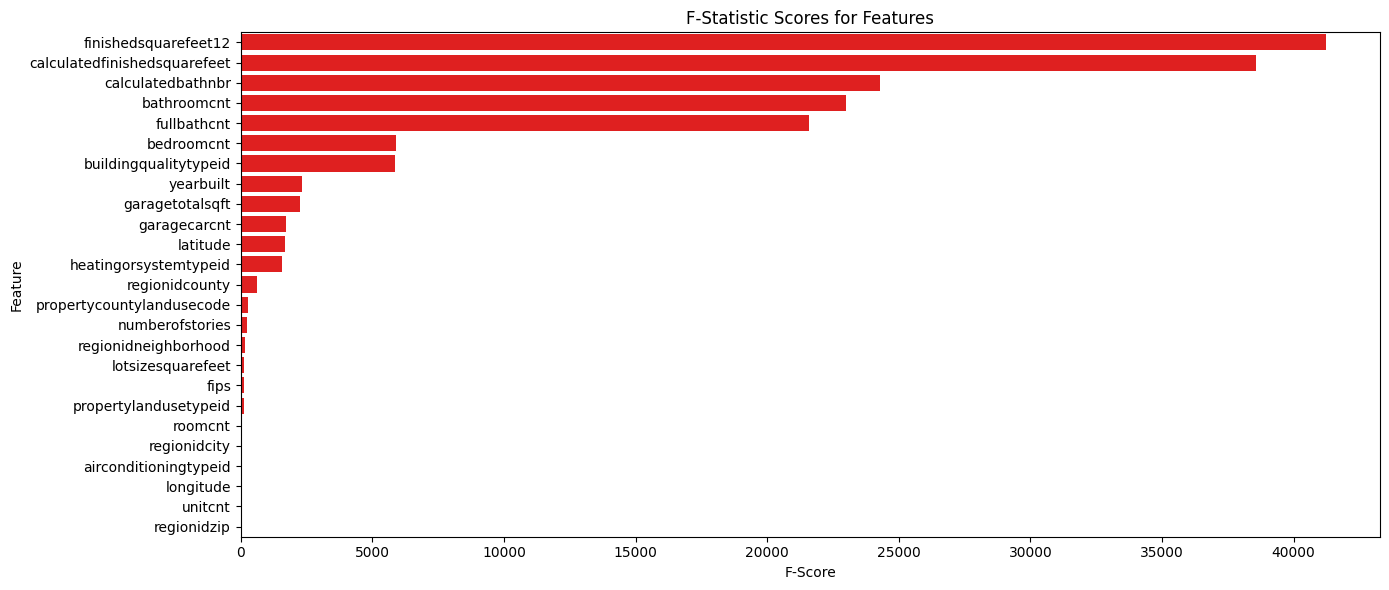

In [26]:
#separate into X and y
X = df_final.drop(columns=['taxvaluedollarcnt']) #exclude taxvaluedollarcnt
y = df_final['taxvaluedollarcnt']
#compute f-stat and p-vals
f_scores, p_vals = f_regression(X, y)
#create dataframe with features, f-score, and p-values to use for visualization
fp_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'p-Value': p_vals
}).sort_values(by='F-Score', ascending=False) #sort by f-score
#plot f-scores
plt.figure(figsize=(14,6))
sns.barplot(x='F-Score', y='Feature', data=fp_df, color='red')
plt.title('F-Statistic Scores for Features')
plt.tight_layout()
plt.show()

##### Identify features with strong correlations or notable relationships that may impact model performance.
From the **correlation matrix**, we can observe several features that have a strong positive correlation with the target variable (taxdollarcnt):
* calculatedfinishedsquarefeet: This tells us that bigger homes have higher values
* finishedsquarefeet12: Similar to calculatedfinishedsquarefeet, both indicate the measured livable area of the property
* roomcnt: This also helps indiacte house size. Homes with more rooms have higher values.
* bathroomcnt / bedroomcnt: Homes with more beds/baths are typically worth more

From the **F-Scores**, we observe several features with the highest F-statistics, showing that these fetaures are linearly associated with the target:
* calculatedfinishedsquarefeet
* finishedsquarefeet12
* roomcnt
* bathroomcnt / bedroomcnt
* buildingqualitytypeid
This confirms what we saw in the correlation matrix, as well as providing the context that buildingqualitytypeid is also highly correlated to the target.

Features with weak **F-scores** and low **correlation**. Although these features may not be strongly correlated to the target itself, they boost the performance of the model by capturing different nuances:
* latitude / longitude: Shows the location-driven price variation; very nonlinear relationship
* regionidcounty: Segmentation of regional market
* buildingqualitytypeid: The strcutural quality of a building affects its value
* garagetotalsqft: Shows that amenities add value to a listing.
* propertycountylandusecode: Categorical type of property (can be useful when encoded)

##### Investigate forward and backward feature selection

In [27]:
#imports
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
#Forward selection
#create linear mode
lr = LinearRegression()
forward_s = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward', scoring='r2', cv=5)
forward_s.fit(X,y)
#print selected features from forward selection
forward_selected_fts = X.columns[forward_s.get_support()].tolist()
print("Forward Selected Features:", forward_selected_fts)

Forward Selected Features: ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', 'latitude', 'longitude', 'regionidcounty', 'roomcnt']


In [28]:
#Backward selection
backward_s = SequentialFeatureSelector(lr, n_features_to_select=10, direction='backward', scoring='r2', cv=5)
backward_s.fit(X,y)
backward_selected_fts = X.columns[backward_s.get_support()].tolist()
print("Backward Selected Features:", backward_selected_fts)

Backward Selected Features: ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'latitude', 'longitude', 'propertycountylandusecode', 'regionidcounty', 'roomcnt']


In [29]:
#check which features overlap selection from forward & backward selection
common_fts = set(forward_selected_fts).intersection(set(backward_selected_fts))
print(common_fts)

{'finishedsquarefeet12', 'longitude', 'buildingqualitytypeid', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'bedroomcnt', 'roomcnt', 'regionidcounty'}


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?

Through analyzation of the relationships among features in the Zillow dataset, several patterns are present. Features such as calculatedfinishedsquarefeet, roomcnt, bathroomcnt, and bedroomcnt are strongly correlated with the target variable, taxvaluedollarcnt. Intuitively, this makes sense since larger homes with more roomstypically have higher assessed values. These relationships are consistent across the correlation matrix and the F-statistic rankings, suggesting strong linear associations. Geographic features like latitude and longitufe have lower linear correlation with taxvaluedollarcnt but were still selected by forward and backward feature selection due to nonlinear regional pricing effects. Categorical variables such as buildingqualitytypeid and propertycountylandusecode also showed moderate influence, showing that property structure and zoning contirbute to a home's price. Overall, the correlation matrix and F-statistics generally agree, highlighting size and room count features and dominant, while feature selection reveals the importance of less obcious predictors like geographic ot categorical context.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

##### **Plot of calculatedfinishedsquarefeet vs. taxvaluedollarcnt**

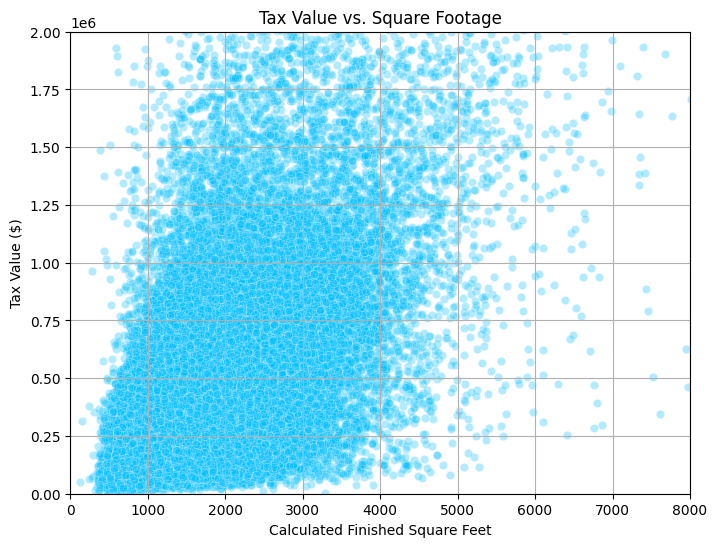

In [30]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x = df_final['calculatedfinishedsquarefeet'],
    y = df_final['taxvaluedollarcnt'],
    alpha = 0.3,
    color='deepskyblue' 
)
plt.title('Tax Value vs. Square Footage')
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Tax Value ($)')
plt.xlim(0, 8000)
plt.ylim(0, 2000000)
plt.grid(True)
plt.show()

#### **Interpretations**

This scatter plot shows a positive relationship between a home's finished square footage and its assessed tax value. As expected, larger homes tend to have a higher assessed tax value. However, there is an increasing spread at higher square footage lebels, suggesting that the presence of luxury homes with varying price-per-square-foot. This supports the use of this feature in any regression model, but non-linear modeling might be needed for this high-end tail.

#### **Plot of buildingqualitytypeid vs. taxvaluedollarcnt**

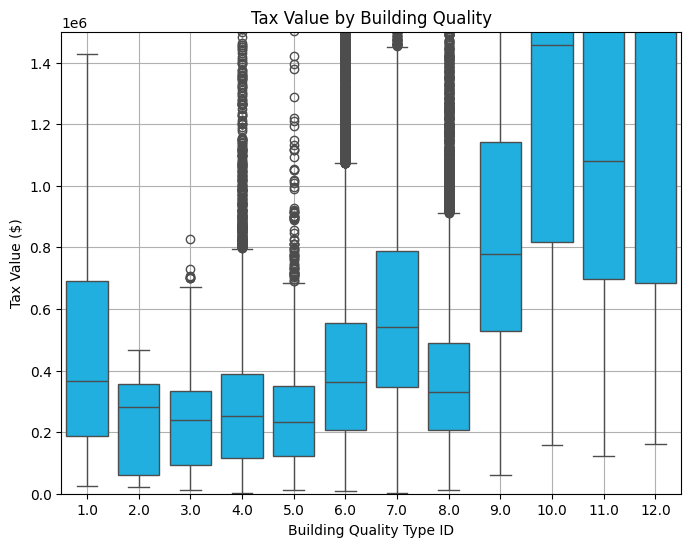

In [31]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df_final,
    x='buildingqualitytypeid',
    y='taxvaluedollarcnt',
    color="deepskyblue"
)
plt.title('Tax Value by Building Quality')
plt.xlabel('Building Quality Type ID')
plt.ylabel('Tax Value ($)')
plt.ylim(0, 1500000)
plt.grid(True)
plt.show()


#### **Interpretations**
This boxplot shows that as building quality increases, the median tax value generally rises. At quality levels 6-8, there is significant variation present, possibly reflecting luxury custom homes. The presence of outliers and large interquartile ranges suggests that this feature is influential, especially when combined with other features such as the size of a property or its location. 

##### **Plot of longitude vs. taxvaluedollarcnt**

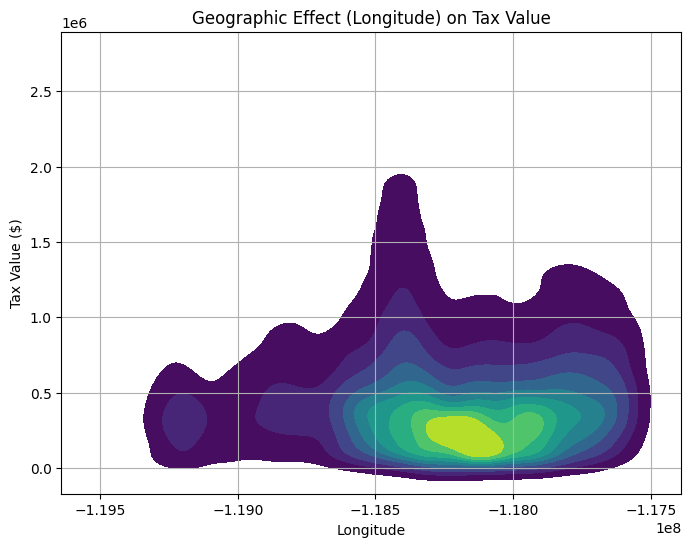

In [32]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    x=df_final['longitude'],
    y=df_final['taxvaluedollarcnt'],
    cmap="viridis", fill=True, bw_adjust=1
)
plt.title('Geographic Effect (Longitude) on Tax Value')
plt.xlabel('Longitude')
plt.ylabel('Tax Value ($)')
plt.grid(True)
plt.show()


#### **Interpretations**
This density plot reveals that there is geographic clustering of tax values present along certain longitude bands. This clustering may reflect coastal or urban regions that have higher property values. This confirms that location is a key factor in tax value assessment, but this is a feature that might be better captured by tree-based models. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

